In [159]:
from pycaret.time_series import *
import pandas as pd

df = pd.read_csv("province/data_eng_day.csv", parse_dates=["timestamp"], index_col="timestamp")
df.index = df.index.normalize()
df = df.drop(columns=["Unnamed: 0"])

print(df.index.duplicated().sum())  # นับจำนวน index ที่ซ้ำกัน
print(df.index[df.index.duplicated()])  # แสดงค่าที่ซ้ำ
df = df[~df.index.duplicated(keep="last")]
df = df.asfreq("D")  # ตั้งค่าความถี่เป็นรายวัน
df = df.interpolate()


# แปลงคอลัมน์ timestamp ให้เป็น DatetimeIndex หากยังไม่ได้ทำ
df.index = pd.to_datetime(df.index)
# ตรวจสอบให้แน่ใจว่าไม่มีคอลัมน์ที่ไม่ต้องการ
df = df[['pm_2_5', 'humidity', 'pm_10', 'temperature']]  # ใช้เฉพาะคอลัมน์ที่ต้องการ

# ลองเรียกใช้งาน setup อีกครั้ง
train_size = int(len(df))-7
train_df = df.iloc[:train_size]  # ใช้ข้อมูลก่อนหน้าทั้งหมดเป็น train set
test_df = df.iloc[train_size:]  
train_df.index = train_df.index.to_period("D")
test_df.index = test_df.index.to_period("D")
print(len(train_df), len(test_df))

1
DatetimeIndex(['2025-02-11'], dtype='datetime64[ns]', name='timestamp', freq=None)
676 7


In [160]:
from pycaret.time_series import TSForecastingExperiment
s = TSForecastingExperiment()


target = 'pm_2_5'
print(train_df["pm_2_5"])





timestamp
2023-04-01     4.727273
2023-04-02     9.656243
2023-04-03    14.585213
2023-04-04    11.938022
2023-04-05    10.733566
                ...    
2025-01-31    24.003417
2025-02-01    31.669725
2025-02-02    32.655212
2025-02-03    35.094660
2025-02-04    24.459172
Freq: D, Name: pm_2_5, Length: 676, dtype: float64


In [161]:
df.tail(10)

,pm_2_5,humidity,pm_10,temperature
timestamp,,,,
2025-02-02,32.655212,70.341639,37.697595,27.683890
2025-02-03,35.094660,65.114261,39.898058,28.644544
2025-02-04,24.459172,70.266522,28.523077,27.775432
2025-02-05,13.987089,71.500943,16.699531,28.327450
2025-02-06,19.454865,69.511783,23.709261,28.579177
2025-02-07,29.321219,70.933952,34.743259,28.271927
2025-02-08,26.000000,69.348548,30.654249,28.385596
2025-02-09,24.616898,69.916384,28.971065,28.373742
2025-02-10,25.856981,71.226336,30.652667,28.251201


In [171]:
# ฟีเจอร์ที่เราจะใช้
features = ['humidity', 'pm_10', 'temperature']

# สร้าง future_exog โดยใช้ PeriodIndex จาก train_df
future_exog = pd.DataFrame(index=pd.period_range(start=train_df.index[-1] + 1, periods=7, freq='D'))

# สร้างฟีเจอร์ Lag สำหรับแต่ละฟีเจอร์
for feature in features:
    # สร้าง Lag 7 วันจากข้อมูลที่ผ่านมา
    future_exog[feature] = train_df[feature].shift(7).iloc[-7:].values

# แสดงผลลัพธ์
print(future_exog)
print(test_df)

             humidity      pm_10  temperature
2025-02-05  75.599793  35.329412    27.671564
2025-02-06  73.888731  44.607143    28.171735
2025-02-07  76.517296  45.566921    27.918719
2025-02-08  86.927369  17.649123    26.477232
2025-02-09  79.552613  34.579310    27.748766
2025-02-10  76.490067  19.396667    28.470961
2025-02-11  73.238003  26.330700    27.879288
               pm_2_5   humidity      pm_10  temperature
timestamp                                               
2025-02-05  13.987089  71.500943  16.699531    28.327450
2025-02-06  19.454865  69.511783  23.709261    28.579177
2025-02-07  29.321219  70.933952  34.743259    28.271927
2025-02-08  26.000000  69.348548  30.654249    28.385596
2025-02-09  24.616898  69.916384  28.971065    28.373742
2025-02-10  25.856981  71.226336  30.652667    28.251201
2025-02-11  29.587755  76.329751  33.787755    27.633866


In [168]:
train_df

,pm_2_5,humidity,pm_10,temperature
timestamp,,,,
2023-04-01,4.727273,73.861694,4.727273,30.189449
2023-04-02,9.656243,70.867094,10.386819,30.042296
2023-04-03,14.585213,67.872493,16.046366,29.895143
2023-04-04,11.938022,62.995952,13.300139,33.853401
2023-04-05,10.733566,59.482051,11.864336,35.772219
...,...,...,...,...
2025-01-31,24.003417,68.520368,28.628702,27.336718
2025-02-01,31.669725,69.231031,36.793578,27.315410
2025-02-02,32.655212,70.341639,37.697595,27.683890


In [ ]:

exp = setup(data=train_df,target=target,fh=7, session_id=123, fold_strategy='expanding',seasonal_period=7, use_gpu=True)
model = create_model('arima')
best = tune_model(model,optimize= "MAE", n_iter=10)
future_predictions = predict_model(best, fh=len(test_df),X=future_exog)
print(future_predictions)

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(676, 4)"
5,Transformed data shape,"(676, 4)"
6,Transformed train set shape,"(669, 4)"
7,Transformed test set shape,"(7, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Th

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,0.0516,0.0485,0.4644,0.5681,0.0123,0.0124,0.9904
1,2025-01-14,0.1231,0.1117,1.1162,1.3143,0.0548,0.0522,0.9882
2,2025-01-21,0.1273,0.1074,1.1612,1.2729,0.0484,0.0483,0.9824
Mean,NaT,0.1007,0.0892,0.9139,1.0518,0.0385,0.0376,0.9870
SD,NaT,0.0347,0.0288,0.3184,0.3424,0.0187,0.0179,0.0034


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,0.0414,0.0364,0.3721,0.4255,0.0100,0.0100,0.9946
1,2025-01-14,0.1071,0.0917,0.9709,1.0787,0.0450,0.0435,0.9921
2,2025-01-21,0.0568,0.0540,0.5178,0.6399,0.0183,0.0181,0.9955
Mean,NaT,0.0684,0.0607,0.6203,0.7147,0.0244,0.0239,0.9941
SD,NaT,0.0281,0.0231,0.2550,0.2718,0.0149,0.0143,0.0015


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.8s finished


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ARIMA,1.2055,1.0644,11.0112,12.6443,0.3876,0.4113,-6.6970


             y_pred
2025-01-29  29.8449
2025-01-30  37.9931
2025-01-31  38.8600
2025-02-01  14.0650
2025-02-02  29.1050
2025-02-03  15.6578
2025-02-04  21.8087


In [164]:
final_best = finalize_model(best)

In [165]:

predictions_future = predict_model(final_best,X=future_exog)
predictions_future

,y_pred
2025-02-05,30.6265
2025-02-06,38.8191
2025-02-07,39.6720
2025-02-08,14.8675
2025-02-09,29.9147
2025-02-10,16.4665
2025-02-11,22.6228


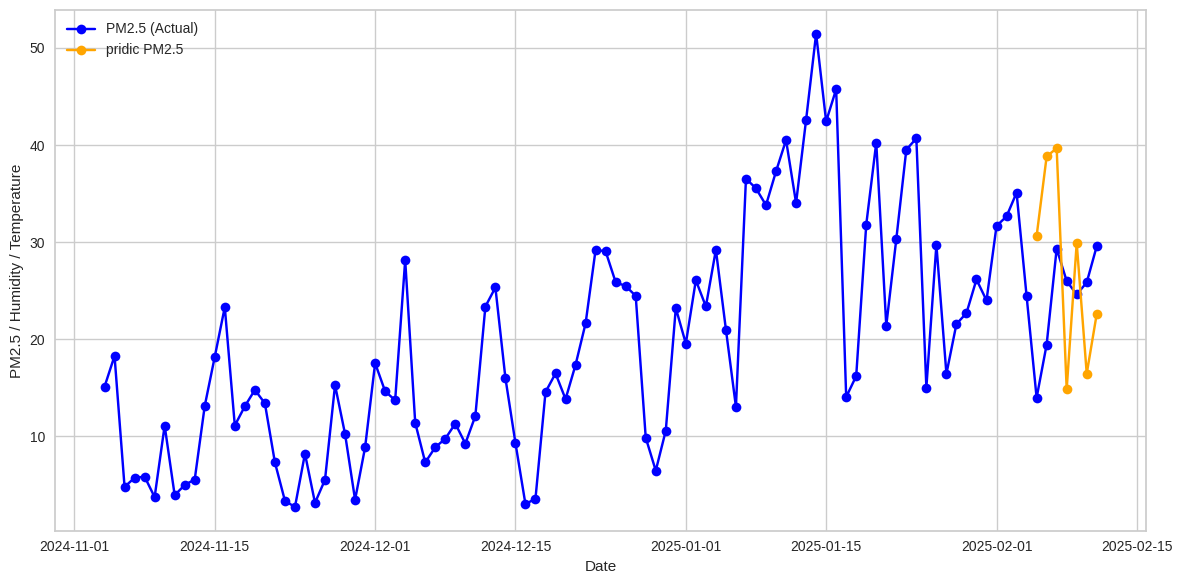

In [166]:
import matplotlib.pyplot as plt

# สร้าง figure และแกน Y แรก
fig, ax1 = plt.subplots(figsize=(12, 6))

# พลอตข้อมูลจาก df บนแกน Y แรก
ax1.plot(df.index[-100:], df['pm_2_5'][-100:], label='PM2.5 (Actual)', color='blue', linestyle='-', marker='o')
# ax1.plot(df.index, df['humidity'], label='Humidity', color='green', linestyle='-', marker='s')
ax1.plot(predictions_future.index,predictions_future, label='pridic PM2.5', color='orange', linestyle='-', marker='o')

# ตั้งค่าแกน Y แรก
ax1.set_xlabel('Date')
ax1.set_ylabel('PM2.5 / Humidity / Temperature')
ax1.tick_params(axis='y')

# สร้างแกน Y ที่สอง
# ax2 = ax1.twinx()

# พลอตข้อมูลจริงและข้อมูลที่ทำนายบนแกน Y ที่สอง
# ax1.plot(actual_values.index, predictions_future, label='Actual PM2.5', color='red', linestyle='--', marker='x')
# ax2.plot(predicted_values.index, predicted_values, label='Predicted PM2.5', color='purple', linestyle='--', marker='d')

# ตั้งค่าแกน Y ที่สอง
# ax2.set_ylabel('PM2.5 (Actual & Predicted)')
# ax2.tick_params(axis='y')

# เพิ่มคำอธิบายเส้น (legend)
lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 , labels1 , loc='upper left')

# เพิ่มกริด
ax1.grid(True)

# ปรับระยะห่างให้เหมาะสม
plt.tight_layout()

# แสดงกราฟ
plt.show()

In [167]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# คำนวณค่า error metrics
# actual_values คือค่าจริงจากข้อมูลทดสอบ (ที่ในที่นี้ใช้ df)
actual_values = df['pm_2_5'][-len(predictions_future):]

# predicted_values คือค่าทำนายจาก model
predicted_values = predictions_future['y_pred']

# คำนวณค่า error
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

# แสดงผลลัพธ์
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 11.30573772
Mean Squared Error (MSE): 149.66760464254438
Root Mean Squared Error (RMSE): 12.233871204265
R-squared (R2): -4.5671992368988965
